## **Prepping foreign city data**

Projected grid: *epsg:28992*
+ road
+ trees
+ memorials
+ nodecount2km

In [ ]:
%pip install osmnx

In [41]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [59]:
import os

os.chdir('c:/Users/chalm/Documents/Sem 2/Computational Intelligence/datasets')

In [113]:
# select location
place_name = "Delft"

### **1. Road Network**

In [114]:
road_network = ox.graph_from_place(place_name, network_type='drive')


In [115]:
#split multiline into individual segments

# Get GeoDataFrame of edges
edges = ox.graph_to_gdfs(road_network, nodes=False, edges=True)

# Split each LineString into individual segments
split_edges = []

for _, row in edges.iterrows():
    line = row.geometry
    if line.geom_type == 'LineString':
        coords = list(line.coords)
        for i in range(len(coords) - 1):
            segment = LineString([coords[i], coords[i + 1]])
            new_row = row.copy()
            new_row.geometry = segment
            split_edges.append(new_row)
    else:
        # Handle MultiLineString or unexpected geometries if needed
        pass

# Create new GeoDataFrame
split_edges_gdf = gpd.GeoDataFrame(split_edges, crs="EPSG:4326")  # Actual original CRS
split_edges_gdf = split_edges_gdf.to_crs(epsg=28992)               # Proper reprojection

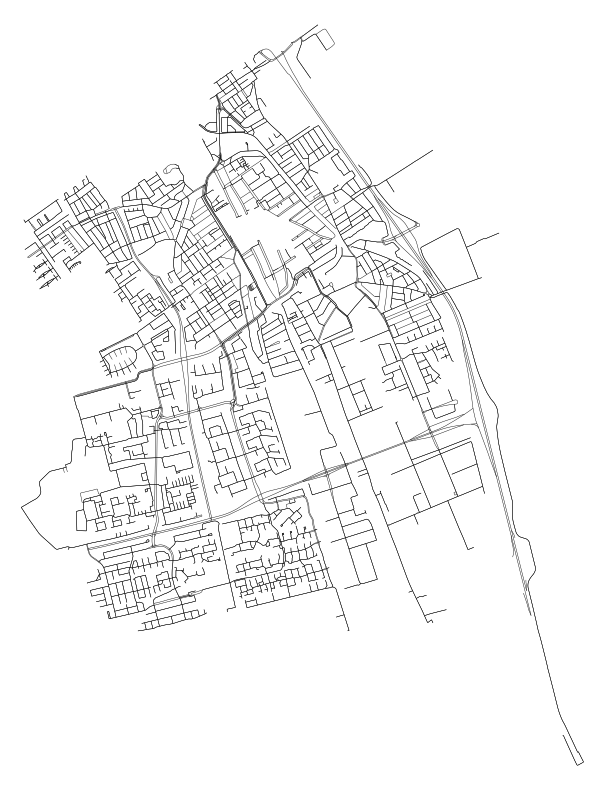

(82005.79124491668, 87515.3177690147, 442351.8109296017, 449608.23883146135)

In [116]:
fig, ax = plt.subplots(figsize=(10, 10))

road_network_proj = ox.project_graph(road_network, to_crs='EPSG:28992')
# plot the road network
ox.plot_graph(road_network_proj, ax=ax, node_size=0, edge_color='black', edge_linewidth=0.3)
# add title and remove axis
ax.set_title(f"Road Network of {place_name}", fontsize=15)
ax.axis('off')

### **2. Get Memorials**

In [117]:
tags = {"historic": "memorial"}
memorials = ox.features_from_place(place_name, tags=tags)

memorials = memorials.to_crs(epsg=28992)

In [118]:
memorials["geometry"] = memorials.geometry.centroid

memorials["Easting"] = memorials.geometry.x
memorials["Northing"] = memorials.geometry.y

memorials_clean = memorials[["Easting", "Northing"]]
memorials_clean.head()
memorials_clean.to_csv(f"{place_name}_memorials.csv", index=False)

In [119]:
memorials_clean.head()

Easting       Northing
element id                                     
node    1368964172  83904.000260  448165.562436
        1391283583  85277.270965  446748.736744
        1394405168  84072.960593  447559.936292
        1456848977  85579.747818  447111.669725
        8445521950  84244.418843  448246.477275

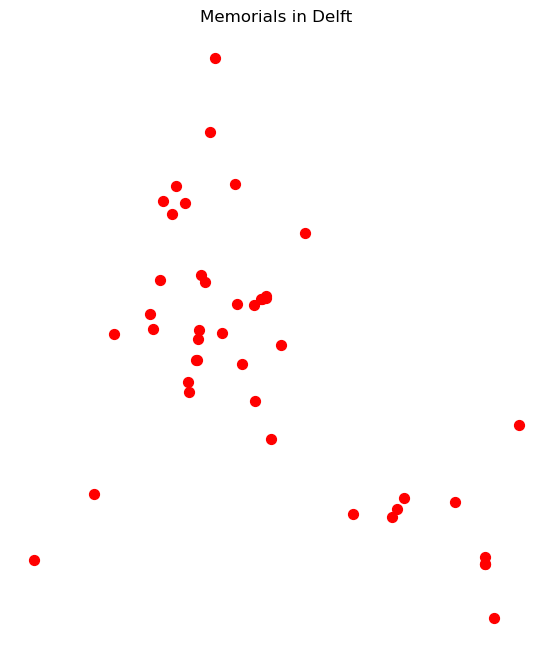

In [120]:
from shapely.geometry import Point

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(memorials_clean["Easting"], memorials_clean["Northing"])]
memorials_gdf = gpd.GeoDataFrame(memorials_clean, geometry=geometry, crs="EPSG:27700")

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
memorials_gdf.plot(ax=ax, color='red', markersize=50)

ax.set_title(f"Memorials in {place_name}")
ax.set_axis_off()
plt.show()

### **3. Get trees**

In [121]:
tags = {"natural": "tree"}

# Step 2: Retrieve tree data (point features only)
trees = ox.features_from_place(place_name, tags)

trees = trees.to_crs(epsg=28992)

In [122]:
trees["geometry"] = trees.geometry.centroid

trees["Easting"] = trees.geometry.x
trees["Northing"] = trees.geometry.y
gdf_trees_clean = trees[["Easting", "Northing"]]
gdf_trees_clean.to_csv(f"{place_name}_trees.csv", index=False)

In [123]:
gdf_trees_clean.head()

Easting       Northing
element id                                     
node    1517432545  84899.841452  447548.454498
        1517432546  84907.863159  447554.940170
        1517432550  84892.043503  447543.234195
        2443441000  84526.225256  447554.177165
        2610954267  83856.870635  447043.917172

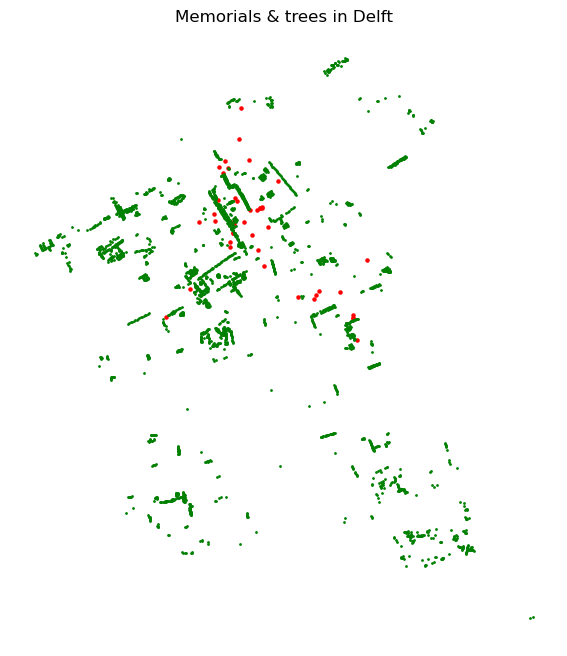

In [124]:
from shapely.geometry import Point

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(gdf_trees_clean["Easting"], gdf_trees_clean["Northing"])]
trees_gdf = gpd.GeoDataFrame(gdf_trees_clean, geometry=geometry, crs="EPSG:27700")

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
memorials_gdf.plot(ax=ax, color='red', markersize=5)
trees_gdf.plot(ax=ax, color='green', markersize=1)

ax.set_title(f"Memorials & trees in {place_name}")
ax.set_axis_off()
plt.show()

### **4. nodecount2km**

In [125]:
import osmnx as ox
import numpy as np
from scipy.spatial import cKDTree
from shapely.geometry import LineString


# Step 1: Project to a UTM / metric CRS
road_network_proj = ox.project_graph(road_network, to_crs='EPSG:28992')

# Step 2: Get node/edge GeoDataFrames
nodes, _ = ox.graph_to_gdfs(road_network_proj, nodes=True, edges=True)

# Step 2: Build KDTree from node coordinates
node_coords = np.array(list(zip(nodes.geometry.x, nodes.geometry.y)))
tree = cKDTree(node_coords)

# Step 3: Loop through split edge segments
nodecount2km = []

for _, edge in split_edges_gdf.iterrows():
    geom = edge.geometry
    if isinstance(geom, LineString):
        midpoint = geom.interpolate(0.5, normalized=True).coords[0]
    else:
        # Fallback or skip
        continue

    # Step 4: Query KDTree
    count = len(tree.query_ball_point(midpoint, r=2000))  # 2 km
    nodecount2km.append(count)

# Step 5: Assign to the GeoDataFrame
split_edges_gdf['nodecount2km'] = nodecount2km


In [126]:
split_edges_gdf.head()

osmid      highway lanes maxspeed            name  \
27082148 44839614 0  48688450     tertiary     2       50   Delfgauwseweg   
         44835830 0   7537370  residential   NaN       30  Spiekmanstraat   
                  0   7537370  residential   NaN       30  Spiekmanstraat   
                  0   7537370  residential   NaN       30  Spiekmanstraat   
                  0   7537370  residential   NaN       30  Spiekmanstraat   

                     oneway reversed      length  \
27082148 44839614 0   False    False  141.011455   
         44835830 0   False     True   39.821403   
                  0   False     True   39.821403   
                  0   False     True   39.821403   
                  0   False     True   39.821403   

                                                              geometry tunnel  \
27082148 44839614 0  LINESTRING (85777.038 447150.231, 85657.261 44...    NaN   
         44835830 0  LINESTRING (85777.038 447150.231, 85772.097 44...    NaN   
                  0  LINESTRING (85772.097 447143.479, 85767.147 44...    NaN   
                  0  LINESTRING (85767.147 447139.075, 85761.034 44...    NaN   
                  0  LINESTRING (85761.034 447135.554, 85745.074 44...    NaN   

                    bridge access  ref width junction  nodecount2km  
27082148 44839614 0    NaN    NaN  NaN   NaN      NaN           979  
         44835830 0    NaN    NaN  NaN   NaN      NaN           945  
                  0    NaN    NaN  NaN   NaN      NaN           946  
                  0    NaN    NaN  NaN   NaN      NaN           947  
                  0    NaN    NaN  NaN   NaN      NaN           953

In [127]:
split_edges_gdf['nodecount2km']

27082148     44839614    0     979
             44835830    0     945
                         0     946
                         0     947
                         0     953
                              ... 
12112770984  44718822    0     896
                         0     894
                         0     893
12114437968  1519889972  0     866
12192370337  629555893   0    1473
Name: nodecount2km, Length: 21745, dtype: int64

In [128]:
# Step 1: Create the mapping dictionary
road_class_map = {
    'residential': 1,     # minor
    'unclassified': 1,
    'tertiary': 2,        # B road
    'secondary': 2,
    'primary': 3,         # A road
    'trunk': 3,
    'motorway': 3
    # Add others if needed
}

# Step 2: Apply the mapping to the edges GeoDataFrame
def get_meridian_class(highway):
    if isinstance(highway, list):  # sometimes 'highway' is a list
        highway = highway[0]
    return road_class_map.get(highway, 1)  # default to 1 (minor)

split_edges_gdf['meridian_class_scale'] = split_edges_gdf['highway'].apply(get_meridian_class)


In [129]:
split_edges_gdf[["osmid", "highway", "length", "geometry", "nodecount2km", "meridian_class_scale"]].head()

osmid      highway      length  \
27082148 44839614 0  48688450     tertiary  141.011455   
         44835830 0   7537370  residential   39.821403   
                  0   7537370  residential   39.821403   
                  0   7537370  residential   39.821403   
                  0   7537370  residential   39.821403   

                                                              geometry  \
27082148 44839614 0  LINESTRING (85777.038 447150.231, 85657.261 44...   
         44835830 0  LINESTRING (85777.038 447150.231, 85772.097 44...   
                  0  LINESTRING (85772.097 447143.479, 85767.147 44...   
                  0  LINESTRING (85767.147 447139.075, 85761.034 44...   
                  0  LINESTRING (85761.034 447135.554, 85745.074 44...   

                     nodecount2km  meridian_class_scale  
27082148 44839614 0           979                     2  
         44835830 0           945                     1  
                  0           946                     1  
                  0           947                     1  
                  0           953                     1

In [130]:
split_edges_gdf.to_csv(f"{place_name}.csv", index=False)